# Code #LikeABosch software challenge - DoorSaver team
This notebook contains the raw data processing, sensor fusion, object tracking and visualization parts

Run each block!

We hope that by providing our solution and algorithms in a notebook format, it is easier to run it across any platform (for evaluation purposes) and the sectioning helps you better understand the code


# Importing the data from Google Drive
The data is downloaded from the provided google drive link and the zip file is extracted


In [1]:
!gdown 1tqtbgjtFRXgSpyfyDzReAHBEO9DxI2dK
!unzip SW\ Challenge\ 2022\ -\ dataset.zip

Downloading...
From: https://drive.google.com/uc?id=1tqtbgjtFRXgSpyfyDzReAHBEO9DxI2dK
To: /content/SW Challenge 2022 - dataset.zip
100% 1.23G/1.23G [00:17<00:00, 71.3MB/s]
Archive:  SW Challenge 2022 - dataset.zip
   creating: SW Challenge 2022 - dataset/
 extracting: SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_14-49_0054.avi  
   creating: SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_14-49_0054.MF4/
  inflating: SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_14-49_0054.MF4/Group_340.csv  
  inflating: SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_14-49_0054.MF4/Group_342.csv  
  inflating: SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_14-49_0054.MF4/Group_343.csv  
  inflating: SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_14-49_0054.MF4/Group_349.csv  
  inflating: SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_14-49_0054.MF4/Group_416.csv  
 extracting: SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_14-49_0054_Rear.avi 

Necessary imports:

In [2]:
import os
import time
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import math as m
import csv

We have 4 datasets, select one by changing the variable `datasetindex`

In [60]:
datasets = [f for f in os.listdir("SW Challenge 2022 - dataset") if f.endswith("MF4")]
print(datasets)
datasetindex = 1

['PSA_ADAS_W3_FC_2022-09-01_15-03_0057.MF4', 'PSA_ADAS_W3_FC_2022-09-01_15-17_0060.MF4', 'PSA_ADAS_W3_FC_2022-09-01_14-49_0054.MF4', 'PSA_ADAS_W3_FC_2022-09-01_15-12_0059.MF4']


#Processing the file contents
A dataset class which reads the CSV files and processes the content:

In [61]:
def readcsv(path):
    with open(path, mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        line_count = 0
        columns = []
        datapoints = {}
        for row in csv_reader:
            if line_count == 0:
                print(f'Column names are {", ".join(row)}')
                columns = [f for f in row]
                line_count += 1
                continue
            t = round(float(row["t"]),2)
            datapoints[t] = row
            line_count += 1
        print(f'[{path}] Processed {line_count} lines.')
        print(f'[{path}] Keys: {columns}')
        return [columns, datapoints]

class Dataset:
    def __init__(self, directoryname):
        self.dirname = directoryname
        self.f340 = readcsv(directoryname +"/Group_340.csv")
        self.f342 = readcsv(directoryname +"/Group_342.csv")
        self.f343 = readcsv(directoryname +"/Group_343.csv")
        self.f349 = readcsv(directoryname +"/Group_349.csv")
        self.f416 = readcsv(directoryname +"/Group_416.csv")
        self.camera_corr_x = 4

    def filter_camera_output(self, t, x, y, vx, vy, objtype, maxdist):
        t2 = []
        x2 = []
        y2 = []
        vx2 = []
        vy2 = []
        obj2 = []
        for i in range(len(t)):
            if objtype[i] > 0 and pow(x[i],2)+pow(y[i],2) < pow(maxdist, 2):
                t2.append(t[i])
                x2.append(x[i])
                y2.append(y[i])
                vx2.append(vx[i])
                vy2.append(vy[i])
                obj2.append(objtype[i])
        return t2, x2, y2, vx2, vy2, obj2

    def get_camera_data_obj(self, id):
        t = []
        x = []
        y = []
        vx = []
        vy = []
        objtype = []
        for i in self.f349[1]:
            t.append(float(self.f349[1][i]['t']))
            x.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_dx'])/128)
            y.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_dy'])/128)
            vx.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_vx'])/256)
            vy.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_vy'])/256)
            objtype.append(int(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_objType']))
            camx = float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_vehicleParameterCal._m_posXCam'])/1000
            camy = float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_vehicleParameterCal._m_posYCam'])/1000
            camz = float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_vehicleParameterCal._m_posZCam'])/1000
            x[-1] += camx+self.camera_corr_x
            y[-1] += camy
        return t, x, y, vx, vy, objtype

    def conv_radar_coord_to_abs(self, id, objid, t, x, y, z, vx, vy, ax, ay, prob):
        angle = 42
        xoffset = 3.4738
        yoffset = 0.6286
        zoffset = 0.5156
        if id == 2:
            angle = 135
            xoffset = -0.7664
            yoffset = 0.738
            zoffet = 0.7359
        elif id == 1:
            angle = -42
            xoffset = 3.4738
            yoffset =-0.6286
            zoffset = 0.5156
        elif id == 3:
            angle = -135
            xoffset = -0.7664
            yoffset = -0.738
            zoffset = 0.7359
        for i in range(len(t)):
            x[i] += xoffset
            y[i] += yoffset
            z[i] += zoffset
        return t, x, y, z, vx, vy, ax, ay, prob

    def filter_radar_invalid(self, id, objid, t, x, y, z, vx, vy, ax, ay, prob, maxdist, maxheight):
        t2 = []
        x2 = []
        y2 = []
        z2 = []
        vx2 = []
        vy2 = []
        ax2 = []
        ay2 = []
        prob2 = []
        for i in range(len(t)):
            if prob[i] > 0.01 and pow(x[i],2)+pow(y[i],2) < pow(maxdist, 2) and z[i] < maxheight:
                t2.append(t[i])
                x2.append(x[i])
                y2.append(y[i])
                z2.append(z[i])
                vx2.append(vx[i])
                vy2.append(vy[i])
                ax2.append(ax[i])
                ay2.append(ay[i])
                prob2.append(prob[i])
        return t2, x2, y2, z2, vx2, vy2, ax2, ay2, prob2

    def get_radar_data_obj(self, id, objid):
        t = []
        x = []
        y = []
        z = []
        vx = []
        vy = []
        ax = []
        ay = []
        prob = []
        for i in self.f349[1]:
            t.append(float(self.f349[1][i]['t']))
            x.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_dx'])/128)
            y.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_dy'])/128)
            z.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_dz'])/128)
            vx.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_vx'])/256)
            vy.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_vy'])/256)
            ax.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_ax'])/2048)
            ay.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_ay'])/2048)
            prob.append(float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_prob1Obstacle'])/128)
        return self.conv_radar_coord_to_abs(id, objid, t,x,y,z,vx,vy,ax,ay,prob)
    
    def get_objects_at(self, time, maxdist, maxheight):
        i = time
        cam_objects = []
        for id in range(15):
            t=float(self.f349[1][i]['t'])
            x=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_dx'])/128
            y=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_dy'])/128
            vx=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_vx'])/256
            vy=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_vy'])/256
            objtype=int(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._'+str(0)+'_._elem._m_camData._m_objects._m_value._'+str(id)+'_._m_objType'])
            camx = float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_vehicleParameterCal._m_posXCam'])/1000
            camy = float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_vehicleParameterCal._m_posYCam'])/1000
            camz = float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_vehicleParameterCal._m_posZCam'])/1000
            if objtype > 0 and pow(x,2)+pow(y,2) < pow(maxdist, 2):
                neu = {}
                neu["x"] = x+camx+self.camera_corr_x
                neu["y"] = y+camy
                neu["vx"] = vx
                neu["vy"] = vy
                neu["type"] = objtype
                neu["id"] = id
                neu["sensorid"] = -1
                cam_objects.append(neu)
        radar_objects = []
        for id in range(4):
            for objid in range(10):
                angle = 42
                xoffset = 3.4738
                yoffset = 0.6286
                zoffset = 0.5156
                if id == 2:
                    angle = 135
                    xoffset = -0.7664
                    yoffset = 0.738
                    zoffet = 0.7359
                elif id == 1:
                    angle = -42
                    xoffset = 3.4738
                    yoffset =-0.6286
                    zoffset = 0.5156
                elif id == 3:
                    angle = -135
                    xoffset = -0.7664
                    yoffset = -0.738
                    zoffset = 0.7359
                t=float(self.f349[1][i]['t'])
                x=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_dx'])/128
                y=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_dy'])/128
                z=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_dz'])/128
                vx=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_vx'])/256
                vy=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_vy'])/256
                ax=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_ax'])/2048
                ay=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_ay'])/2048
                prob=float(self.f349[1][i]['_g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_arrayPool._0_._elem._m_cornerData._m_value._'+str(id)+'_._m_objects._m_value._'+str(objid)+'_._m_prob1Obstacle'])/128
                if prob > 0.01 and pow(x,2)+pow(y,2) < pow(maxdist, 2) and z < maxheight:
                    neu = {}
                    neu["x"] = x+xoffset
                    neu["y"] = y+yoffset
                    neu["z"] = z+zoffset
                    neu["vx"] = vx
                    neu["vy"] = vy
                    neu["ax"] = ax
                    neu["ay"] = ay
                    neu["prob"] = prob
                    neu["sensorid"] = id
                    neu["id"] = objid
                    radar_objects.append(neu)
        return cam_objects, radar_objects

Instantiating the Dataset class

The constructor's only parameter is the folder path for the csv files

In [62]:
d = Dataset("SW Challenge 2022 - dataset/"+datasets[datasetindex])

Column names are t, Hunter_GPS_Mode
[SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_15-17_0060.MF4/Group_340.csv] Processed 30001 lines.
[SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_15-17_0060.MF4/Group_340.csv] Keys: ['t', 'Hunter_GPS_Mode']
Column names are t, Lat_Delta_Distance, Lat_Delta_Velocity
[SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_15-17_0060.MF4/Group_342.csv] Processed 30001 lines.
[SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_15-17_0060.MF4/Group_342.csv] Keys: ['t', 'Lat_Delta_Distance', 'Lat_Delta_Velocity']
Column names are t, Long_Delta_Distance, Long_Delta_Velocity
[SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_15-17_0060.MF4/Group_343.csv] Processed 30001 lines.
[SW Challenge 2022 - dataset/PSA_ADAS_W3_FC_2022-09-01_15-17_0060.MF4/Group_343.csv] Keys: ['t', 'Long_Delta_Distance', 'Long_Delta_Velocity']
Column names are t, _g_Infrastructure_CCR_NET_NetRunnablesClass_m_rteInputData_out_local.TChangeableMemPool._._._m_array

#Sensor fusion and object tracking

In [63]:
def check_obj_same_id(oold, onew, tdiff):
    if "dead" in oold:
        dist_x = abs(oold["x"]+oold["vx"]*tdiff-onew["x"])
        dist_y = abs(oold["y"]+oold["vy"]*tdiff-onew["y"])
        dist = m.sqrt(pow(dist_x,2)+pow(dist_y,2))
        return dist < 8
    if oold["sensorid"] == onew["sensorid"] and oold["id"] == onew["id"]:
        dist_x = abs(oold["x"]+oold["vx"]*tdiff-onew["x"])
        dist_y = abs(oold["y"]+oold["vy"]*tdiff-onew["y"])
        dist = m.sqrt(pow(dist_x,2)+pow(dist_y,2))
        return dist < 6
    return False
def get_mean_data(s):
    vx = 0
    vy = 0
    x = 0
    y = 0
    for i in s:
        vx += i["vx"]/len(s)
        vy += i["vy"]/len(s)
        x += i["x"]/len(s)
        y += i["y"]/len(s)
    return x, y, vx, vy
def check_possible_connection(obj1, obj2):
    obj1dist = m.sqrt(pow(obj1["x"],2)+pow(obj1["y"],2))
    obj2dist = m.sqrt(pow(obj2["x"],2)+pow(obj2["y"],2))
    if obj1["sensorid"] == obj2["sensorid"]:
        return False
    dist_x = abs(obj1["x"]-obj2["x"])
    dist_y = abs(obj1["y"]-obj2["y"])
    dist = m.sqrt(pow(dist_x,2)+pow(dist_y,2))
    vdist = m.sqrt(pow(obj1["vx"]-obj1["vy"],2)+pow(obj2["vy"]-obj2["vy"],2))
    if obj1dist < 40 and obj2dist < 40:
        if vdist > 10:
            return False
        if dist < 6:
            return True
    if vdist > 6:
        return False
    return dist < 5
def get_mean_data(s):
    vx = 0
    vy = 0
    x = 0
    y = 0
    for i in s:
        vx += i["vx"]/len(s)
        vy += i["vy"]/len(s)
        x += i["x"]/len(s)
        y += i["y"]/len(s)
    return x, y, vx, vy
def calculate_and_estimate_next_positions(objset, timediff, t):
    global current_objs
    news = []
    deadfounds = []
    deadindex = []
    #find old and check if ok, if not, add to new list
    for obj in objset:
        result = False
        deadfound = False
        closestdead = 0
        deaddist = pow(10,10)
        for lst in current_objs:
            escape = False
            if len(lst["curr"]) > 0:
                for item in lst["curr"]:
                    result = check_obj_same_id(item, obj, timediff)
                    if result:
                        lst["new"].append(obj)
                        lst["lasttime"] = t
                        break
                if result:
                    escape = True
            else:
                tmp = {}
                tmp["x"] = lst["mean_x"]
                tmp["y"] = lst["mean_y"]
                tmp["vx"] = lst["mean_vx"]
                tmp["vy"] = lst["mean_vy"]
                tmp["dead"] = True
                result = check_obj_same_id(tmp, obj, timediff)
                if result:
                    dist = m.sqrt(pow(obj["x"]-lst["mean_x"],2)+pow(obj["y"]-lst["mean_y"],2))
                    if deadfound == False:
                        deadfound = True
                        closestdead = lst
                        deaddist = dist
                    elif dist < deaddist:
                        closestdead = lst
                        deaddist = dist
            if escape:
                break
        if result == False: #new object without pair
            if deadfound:
                deadfounds.append(obj)
                deadindex.append(closestdead)
            news.append(obj)
    newobjs = 0
    if len(news) > 0:
        for alone in news:
            found = False
            closest = 0
            closesdist = pow(10,10)
            for lst in current_objs:
                possible = True
                for item in lst["new"]:
                    if not check_possible_connection(alone, item):
                        possible = False
                if possible and len(lst["new"]) > 0: #no conflicts + not disappearing object
                    ox,oy,_,_ = get_mean_data(lst["new"])
                    dist = m.sqrt(pow(alone["x"]-ox,2)+pow(alone["y"]-oy,2))
                    found = True
                    if dist < closesdist:
                        closesdist = dist
                        closest = lst
            if found:
                closest["new"].append(alone)
                closest["lasttime"] = t
            elif alone in deadfounds:
                idx = deadfounds.index(alone)
                deadindex[idx]["new"].append(alone)
                deadindex[idx]["lasttime"] = t
                deadfounds.remove(alone)
                deadindex.remove(deadindex[idx])
                while alone in deadfounds:
                    idx = deadfounds.index(alone)
                    deadfounds.remove(alone)
                    deadindex.remove(deadindex[idx])
            else:
                neu = {}
                neu["tcreated"] = t
                neu["new"] = [alone]
                neu["curr"] = []
                neu["lasttime"] = t
                current_objs.append(neu)
                newobjs += 1
    k = len(current_objs)
    current_objs = [x for x in current_objs if t-x["lasttime"] < 10] #keeping track of lost objects for 10 seconds
    for c in current_objs:
        if len(c["new"]) > 0:
            c["mean_x"], c["mean_y"], c["mean_vx"], c["mean_vy"] = get_mean_data(c["new"])
            c["curr"] = c["new"]
            c["new"] = []
        else:
            if len(c["curr"]) > 0:
                c["mean_x"], c["mean_y"], c["mean_vx"], c["mean_vy"] = get_mean_data(c["curr"])  
            c["mean_x"] += c["mean_vx"]*timediff
            c["mean_y"] += c["mean_vy"]*timediff
            c["curr"] = []
    
    toremove = []
    deads = [u for u in current_objs if len(u["curr"]) == 0]
    for c in deads:
        delneeded = False
        nonempty = [x for x in current_objs if len(x["curr"]) > 0]
        for ne in nonempty:
            dist = m.sqrt(pow(ne["mean_x"]-c["mean_x"],2)+pow(ne["mean_y"]-c["mean_y"],2))
            if dist < 6:
                delneeded = True
        if delneeded:
            toremove.append(c)
    current_objs = [x for x in current_objs if x not in toremove] #removing overlapping dead objects
    return newobjs, k-len(current_objs)


Running the sensor fusion with a simple visulaization:

(It may flicker, so exporting the video (which is located in the next block) is a better but slower option)

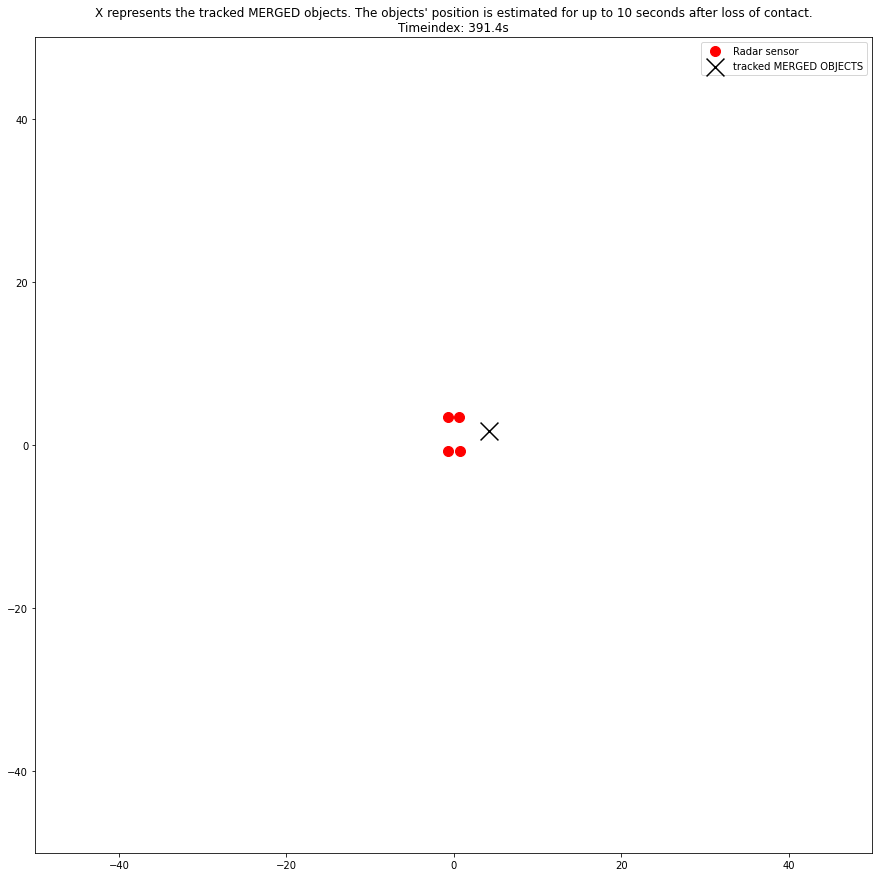

KeyboardInterrupt: ignored

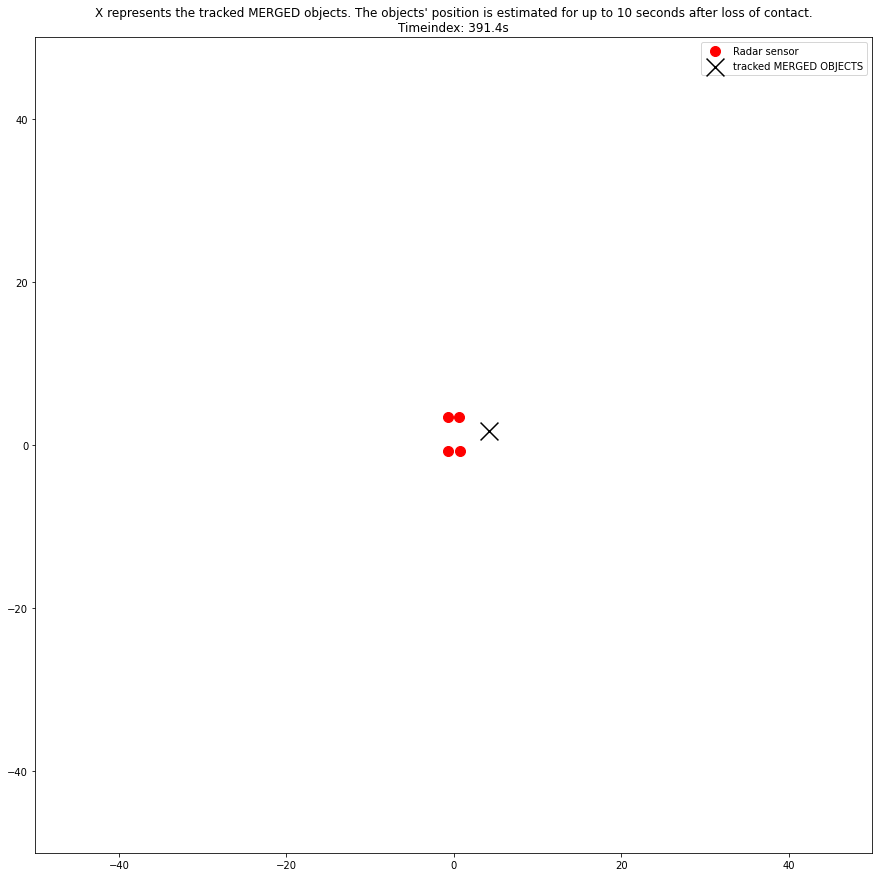

In [64]:
timestamps = list(d.f349[1].keys())
current_objs = []
t_prev = timestamps[0]

deltat = 0.1
plt.rcParams['figure.figsize'] = [15, 15]
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
ax1.grid(False)
display.clear_output(wait=True)
display.display(plt.gcf())
time.sleep(deltat)
for u in range(len(timestamps)):
    k = timestamps[u]
    cam, rad = d.get_objects_at(k,50,3)
    newobjs, delobjs = calculate_and_estimate_next_positions(cam + rad, timestamps[u]-t_prev, k)
    t_prev = timestamps[u]
    if u%10 != 0:
        continue
    ax1.clear()
    ax1.set_xlim(-50,50)
    ax1.set_ylim(-50,50)
    sensordata = {}
    for i in cam+rad:
        if i["sensorid"] not in sensordata:
            sensordata[i["sensorid"]] = [[],[]]
        sensordata[i["sensorid"]][0].append(-i["y"])
        sensordata[i["sensorid"]][1].append(i["x"])
    
    if -1 in sensordata:
        ax1.scatter(sensordata[-1][0],sensordata[-1][1], c='m', marker='o', label="Datapoints from CAMERA", s=80)
    if 0 in sensordata: 
        ax1.scatter(sensordata[0][0],sensordata[0][1], c='k', marker='o', label="Datapoints from FRONT LEFT RADAR", s=80)
    if 1 in sensordata: 
        ax1.scatter(sensordata[1][0],sensordata[1][1], c='g', marker='o', label="Datapoints from FRONT RIGHT RADAR", s=80)
    if 2 in sensordata: 
        ax1.scatter(sensordata[2][0],sensordata[2][1], c='b', marker='o', label="Datapoints from REAR LEFT RADAR", s=80)
    if 3 in sensordata: 
        ax1.scatter(sensordata[3][0],sensordata[3][1], c='y', marker='o', label="Datapoints from REAR RIGHT RADAR", s=80)
    obj_x = [-i["mean_y"] for i in current_objs]
    obj_y = [i['mean_x'] for i in current_objs]
    ax1.scatter(obj_x, obj_y, c='k', marker='x', s=320, label="tracked MERGED OBJECTS")
    
    ax1.plot(-0.6286,3.4738, "ro", label='Radar sensor', markersize=10)
    ax1.plot(0.6286,3.4738, "ro", markersize=10)
    ax1.plot(0.738, -0.7664, "ro", markersize=10)
    ax1.plot(-0.738, -0.7664, "ro", markersize=10)
    ax1.set_title('X represents the tracked MERGED objects. The objects\' position is estimated for up to 10 seconds after loss of contact.\nTimeindex: '+str(k) + "s")
    ax1.legend()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(deltat)

# Saving the video as an mp4 file
the file can be downloaded from the filesystem. To make it faster, only every 10th frame is saved.

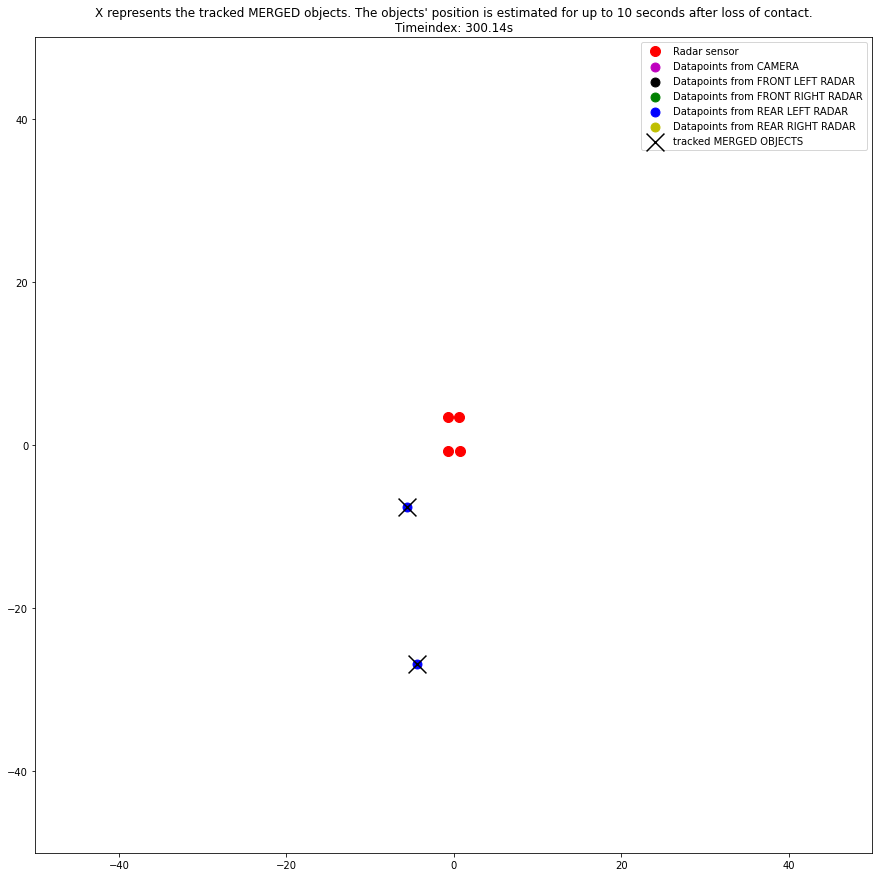

In [65]:
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

timestamps = list(d.f349[1].keys())
current_objs = []

t_prev = timestamps[0]
fig, ax1 = plt.subplots()
dat = {
    -1: [[],[]],
    0 : [[],[]],
    1 : [[],[]],
    2 : [[],[]],
    3 : [[],[]]
}
scC = ax1.scatter(dat[-1][0],dat[-1][1], c='m', marker='o', label="Datapoints from CAMERA", s=80)
sc0 = ax1.scatter(dat[0][0],dat[0][1], c='k', marker='o', label="Datapoints from FRONT LEFT RADAR", s=80)
sc1 = ax1.scatter(dat[1][0],dat[1][1], c='g', marker='o', label="Datapoints from FRONT RIGHT RADAR", s=80)
sc2 = ax1.scatter(dat[2][0],dat[2][1], c='b', marker='o', label="Datapoints from REAR LEFT RADAR", s=80)
sc3 = ax1.scatter(dat[3][0],dat[3][1], c='y', marker='o', label="Datapoints from REAR RIGHT RADAR", s=80)
mrgx = []
mrgy = []
mrg = ax1.scatter(mrgx, mrgy, c='k', marker='x', s=320, label="tracked MERGED OBJECTS")
plt.xlim(-50,50)
plt.ylim(-50,50)
ax1.plot(-0.6286,3.4738, "ro", label='Radar sensor', markersize=10)
ax1.plot(0.6286,3.4738, "ro", markersize=10)
ax1.plot(0.738, -0.7664, "ro", markersize=10)
ax1.plot(-0.738, -0.7664, "ro", markersize=10)
ax1.legend()
ax1.set_title('X represents the tracked MERGED objects. The objects\' position is estimated for up to 10 seconds after loss of contact.\nTimeindex: '+str(0) + "s")
def animate(u0):
    global t_prev, d, dat, current_objs
    for l in range(10):
        u = u0*10+l
        k = timestamps[u]
        cam, rad = d.get_objects_at(k,50,3)
        newobjs, delobjs = calculate_and_estimate_next_positions(cam + rad, timestamps[u]-t_prev, k)
        t_prev = timestamps[u]
        sensordata = {}
        for i in cam+rad:
            if i["sensorid"] not in sensordata:
                sensordata[i["sensorid"]] = [[],[]]
            sensordata[i["sensorid"]][0].append(-i["y"])
            sensordata[i["sensorid"]][1].append(i["x"])
        for i in range(-1,4):
            if i in sensordata:
                dat[i][0] = sensordata[i][0]
                dat[i][1] = sensordata[i][1]
            else:
                dat[i][0] = []
                dat[i][1] = []
        mrgx = [-i["mean_y"] for i in current_objs]
        mrgy = [i['mean_x'] for i in current_objs]
    scC.set_offsets(np.c_[dat[-1][0],dat[-1][1]])
    sc0.set_offsets(np.c_[dat[0][0],dat[0][1]])
    sc1.set_offsets(np.c_[dat[1][0],dat[1][1]])
    sc2.set_offsets(np.c_[dat[2][0],dat[2][1]])
    sc3.set_offsets(np.c_[dat[3][0],dat[3][1]])
    mrg.set_offsets(np.c_[mrgx, mrgy])
    ax1.set_title('X represents the tracked MERGED objects. The objects\' position is estimated for up to 10 seconds after loss of contact.\nTimeindex: '+str(k) + "s")


ani = matplotlib.animation.FuncAnimation(fig, animate, 
                frames=int(len(timestamps)/10), interval=100, repeat=False) 
ani.save("video.mp4")
plt.show()
